<br/>

$$ \huge{\underline{\textbf{ REINFORCE with Baseline }}} $$

<br/>

<center>Implementation of <b>REINFORCE with Baseline</b> algorithm</center>
<center>from Sutton and Barto 2018, <b>chapter 13.4</b>.</center>
<center>Book available for free <a href="http://incompleteideas.net/book/the-book-2nd.html">here</a></center>

<br/>

<img src="assets/1304_REINFORCE_With_Baseline.png"/>
<center> From Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 13.4 </center>

<br/>

Implementation of REINFORCE algorithm.

In [1]:
def REINFORCE_with_baseline(env, ep, gamma, alpha_w, alpha_theta, baseline, init_theta=None):
    """REINFORCE algorithm.
    
    Params:
        env: OpenAI-like environment
        ep (int): number of episodes to run
        gamma (float): discount factor
        alpha_w (float): learning rate for state-value function
        alpha_theta (float): learning rate for policy
        init_theta (np.array): initialize policy weights, default np.zeros()
    """
    def policy(st, pi):
        return np.random.choice(range(env.nb_actions), p=pi.pi(st))

    hist_R = []
    hist_val = []
    hist_prob = []
    
    v_hat = TabularStateValueFunction(lr=alpha_w, nb_states=env.nb_states)
    pi = TabularSoftmaxPolicy(lr=alpha_theta,
                              nb_states=env.nb_states,
                              nb_actions=env.nb_actions,
                              init_theta=init_theta)

    for e_ in range(ep):
        # traj = [(st, rew, done, act), (st, rew, done, act), ...]
        traj, T = generate_episode(env, policy, pi)
        
        R_sum = traj[T][1]
        for t in range(0, T):
            St, Rt, _, At = traj[t]      # (st, rew, done, act)
            Gt = sum([gamma**(k-t-1) * traj[k][1] for k in range(t+1, T+1)])
            v_hat.train(St, Gt)          # delta calculated internally
            delta = Gt - v_hat.evaluate(St) if baseline else Gt
            pi.update(St, At, gamma**t * delta)
            R_sum += 0 if Rt is None else Rt
        
        hist_R.append(R_sum)
        hist_val.append(v_hat.evaluate(St))
        hist_prob.append(pi.pi(St))
        
    hist_R = np.array(hist_R)
    hist_val = np.array(hist_val)
    hist_prob = np.array(hist_prob)
    
    return hist_R, hist_val, hist_prob

Helper functions:

In [2]:
def generate_episode(env, policy, *params):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done    = env.reset(), None, False
        else:     St, Rt, done, _ = env.step(At)
        At = policy(St, *params)
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

<table>
    <tr>
        <td style="border-color: white;"><img src="assets/fig_1302.png"/></td>
    </tr>
    <tr>
        <td style="border-color: white;"><center>Figure 13.2<center/></td>
    </tr>
</table>

---

# Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class CorridorSwitchedEnv:
    """Short corridor with switched actions. See example 13.1 in the book.
    
    Note: Small change introduced to terminate after time step 1000
          to prevent infinite loop if policy becomes deterministic.
    """
    def __init__(self):
        self.nb_states = 1
        self.nb_actions = 2
        self._state = 0
        self._curr_iter = 0
        
    def reset(self):
        self._state = 0
        self._curr_iter = 0
        return 0    # states are indistinguisable
    
    def step(self, action):
        assert action in [0, 1]    # left, right
        
        if self._state == 0:
            if action == 1:
                self._state = 1
        elif self._state == 1:
            if action == 0:        # left, swapped to right
                self._state = 2
            else:                  # right, swapped to left
                self._state = 0
        elif self._state == 2:
            if action == 0:
                self._state = 1
            else:
                self._state = 3    # terminal
        else:
            raise ValueError('Invalid state:', self._state)
        
        # Terminate at time step = 1000
        self._curr_iter += 1
        if self._curr_iter >= 1000:
            self._state = 3
        
        if self._state == 3:
            return 0, -1, True, None    # obs, reward, done, extra
        else:
            return 0, -1, False, None

# Policy Function

In [5]:
def onehot(i, size):
    """One-hot vector of size 'size'."""
    vec = np.zeros(size)
    vec[i] = 1
    return vec

In [6]:
def softmax(x):
    """Numerically stable softmax"""
    ex = np.exp(x - np.max(x))
    return ex / np.sum(ex)

Mathematically it would be one-hot encoded state dot product with weights. Which can be simplified as a lookup table.

In [7]:
class TabularStateValueFunction:
    """Tabular state-value function 'approximator'"""
    def __init__(self, lr, nb_states):
        self._lr = lr
        self._w = np.zeros(nb_states)
    
    def evaluate(self, state):
        # or onehot(state, nb_states) @ self._w
        return self._w[state]
    
    def train(self, state, target):
        value = self.evaluate(state)
        self._w[state] += self._lr * (target - value)

Same goes for policy function. Linear combination of features with softmax on top is implemented as a lookup table.

In [8]:
class TabularSoftmaxPolicy:
    """Tabular action-state function 'approximator'"""
    def __init__(self, lr, nb_states, nb_actions, init_theta=None):
        self._lr = lr                                   # learning rate
        self.n_act = nb_actions
        self._theta = np.zeros((nb_states, nb_actions))  # weights
        if init_theta is not None:
            assert init_theta.dtype == np.float64
            assert init_theta.shape == self._theta.shape
            self._theta = init_theta
    
    def pi(self, state):
        """Return policy, i.e. probability distribution over actions."""
        h_vec = self._theta[state]
        prob_vec = softmax(h_vec)                     # shape=[n_act], e.q. 13.2
        return prob_vec


    def update(self, state, action, disc_return):
        x_s = np.zeros(self.n_act)
        x_s[action] = 1             # feature vector, one-hot
        prob = self.pi(state)
        grad_s = x_s - prob
        self._theta[state] += self._lr * disc_return * grad_s

# Recreate figure 13.2

We will use multiprocessing to speed things up (by a lot!)

In [9]:
import multiprocessing as mp

In [10]:
def run_single_experiment(alpha_w, alpha_theta, baseline):
    np.random.seed()  # required due to multiprocessing
    env = CorridorSwitchedEnv()
    hist_R, _, _ = REINFORCE_with_baseline(
        env, ep=1000, gamma=1.0, alpha_w=alpha_w, alpha_theta=alpha_theta,
        baseline=baseline, init_theta=np.array([[1.47, -1.47]]))
    return hist_R

In [11]:
def run_multiple_exp(repeat, alpha_w, alpha_theta, baseline):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        param_list = [(alpha_w, alpha_theta, baseline)] * repeat
        results = pool.starmap(run_single_experiment, param_list)
        results = np.array(results)         # shape [nb_repeat, nb_episodes]
        return np.average(results, axis=0)  # shape [nb_episodes]

In [12]:
runs_a13_avg = run_multiple_exp(repeat=100, alpha_w=0.0, alpha_theta=2**-13, baseline=False)
runs_aw6_at9_avg = run_multiple_exp(repeat=100, alpha_w=2**-6, alpha_theta=2**-9, baseline=True)

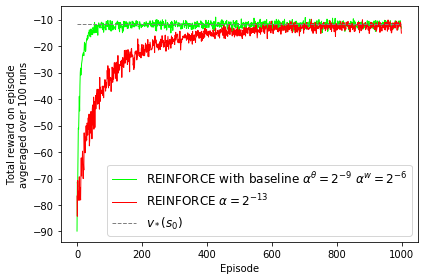

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(runs_aw6_at9_avg, linewidth=1.0, color='lime',
        label='REINFORCE with baseline $\\alpha^\\theta=2^{-9}$ $\\alpha^w=2^{-6}$')
ax.plot(runs_a13_avg, linewidth=1.0, color='red', label='REINFORCE $\\alpha=2^{-13}$')
ax.plot([-11.6]*1000, linewidth=1.0, linestyle='--', color='gray', label='$v_*(s_0)$')
ax.set_ylabel('Total reward on episode\navgeraged over 100 runs')
ax.set_xlabel('Episode')
ax.legend(prop={'size': 12})
plt.tight_layout()
plt.savefig('assets/fig_1302.png')
plt.show()